In [6]:
# basic set up
import numpy as np
import time
import matplotlib.pyplot as plt
import astropy.io.fits as pyfits
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord
from shapely.geometry import Point
from matplotlib.path import Path
from astropy.io import fits, ascii
from astropy.table import Column

# debug
import pdb


In [51]:
# TODO: read targets are possibly not needed to prepare the pointing centers
def read_targets(data_dir, prefix, fmt='fits'):
    '''
    Read the targets data from the file.
    '''
    if prefix is None:
        raise ValueError('Give prefix (cos, sky, or star) of data file!')

    # Read the data table
    data_fn = data_dir + prefix + '_targets.' + fmt
    if fmt == 'fits':
        data_table = Table.read(data_fn, format='fits')
    elif fmt == 'ecsv':
        data_table = Table.read(data_fn, format='ascii.ecsv')
    else:
        raise ValueError('The format is not supported!')

    return data_table

# TODO: needs to be revised once the tiling strategy is finalized    
def predefine_pointing_centers(ra_min, ra_max, dec_min, dec_max, xscale=1., yscale=1., diameter=1.38):
    '''determine the pointing centers of PFS polygons, assuming no overlapping of polygons
    
    NOTE (need revision)
    ==========
    here we assume flat sky, i.e. the curvature of the sky is neglected.
    
    Parameters
    ==========
    ra_min, ra_max, dec_min, dec_max : float
        ra, dec range of the region
    diameter: float, in. deg
        PFS FoV diameter
    xscale, yscale: float
        (0.5, 1], 1 means no overlapping and <1 means overlapping
        
    Returns
    =======
    numpy array of pointing centers
    '''
    #initialize the first pointing 
    side = diameter/2. 
    height = np.sqrt(3.)/2.*side 
    
    #no overlapping of hexagons, i.e. max dist 
    ydist0 = 2*height
    xdist0 = (3./2.*side) 
    
    ydist = ydist0*xscale
    xdist = xdist0*yscale
    
    np_ra = int((ra_max - ra_min)/xdist) + 2
    np_dec = int((dec_max - dec_min)/ydist) + 2
    
    peak = []
    #initialize the first two pointing centers
    '''
    bench = "calibration"
    '''
    peak_x0, peak_y0 = ra_min, [dec_min, dec_min+ydist/2.]
    for i in range(np_ra):
        peak_x = peak_x0 + i*xdist
        for j in range(np_dec):
            peak_y = peak_y0[i%2] + j*ydist
            peak.append([peak_x, peak_y])
    
    return np.array(peak)

def save_pointings(peak, filename, fmt='ascii.ecsv'):
    '''save the pointing centers to a file

    Columns that must be included:
    ppc_code, ppc_ra, ppc_dec, ppc_pa, ppc_resoltion, ppc_priority, obstime
    
    Parameters
    ==========
    peak: list
        list of pointing centers
    filename: string
        name of the file
    '''

    # TODO: finalize the ppc_code format - field, pass, tile id
    # TODO: figure out about ppc_priority
    npeak = len(peak)
    pointings = Table()
    pointings['ppc_code'] = ['Autumn_'+str(x) for x in range(npeak)]
    # TODO: shoud we make sure %.3f for ra and dec?
    pointings['ppc_ra'] = np.round(peak[:,0], 3)
    pointings['ppc_dec'] = np.round(peak[:,1], 3)
    pointings['ppc_pa'] = np.zeros(npeak) + 0.
    pointings['ppc_resolution'] = Column(['L'] * npeak, dtype = np.str_)
    pointings['ppc_priority'] = Column(np.zeros(npeak) + 1, dtype = np.int32)
    pointings['obstime'] = Column(np.full(npeak, np.nan)) 

    pointings.write(filename, format=fmt, overwrite=True)

    print('Pointing centers are saved to %s' % filename)


def plot_filter_fov(raP, decP, raSci, decSci, PA=0, n_sci_fov_least=3000, filter_fov=True):
    '''plot one PFS FoV (hexagon) centered at the pointing center
    
    NOTE
    ==========
    flag_fov_reserved is obtained by using a threshold of targets in the FoV

    Parameters
    ==========
    raP, decP, PA : float
        ra, dec, PA of the pointing center

    raSci, decSci: numpy array, float
        ra, dec of the scientific targets
        only used to check the number of scientific targets in the FoV
    
    n_sci_fov_least: int
        the least number of scientific targets in the FoV

    filter_fov: Boolean
        if True, plot/select the FoV only when there are enough scientific targets in the FoV

        
    Returns
    =======
    plot a hexagon at the pointing center with diameter=1.38 deg
    
    flag_fov_reserved: Boolean, used to remove the pointing w/o enough scientific targets 
    '''
    
    center = SkyCoord(raP*u.deg, decP*u.deg)
    # PA=0 along y-axis, PA=90 along x-axis, PA=180 along -y-axis...
    hexagon = center.directional_offset_by([0+PA, 60+PA, 120+PA, 180+PA, 240+PA, 300+PA, 360+PA]*u.deg, 1.38/2.*u.deg)
    ra_h = hexagon.ra.deg
    dec_h = hexagon.dec.deg

    ra_h_in = np.where(np.fabs(ra_h-center.ra.deg)>180)
    if len(ra_h_in[0])>0:
        if ra_h[ra_h_in[0][0]]>180:ra_h[ra_h_in[0]]-=360
        elif ra_h[ra_h_in[0][0]]<180:ra_h[ra_h_in[0]]+=360
        #pdb.set_trace()

    # note ra range is [-180, 180] for HSC wide autumn field
    ra_h[ra_h>300] -= 360

    # scientific targets
    point = np.vstack((raSci, decSci)).T
    
    # TODO: revise the polygon.contains_points for the ra near 0 and 360 cases
    if filter_fov:
        polygon = Path([(ra_h[t],dec_h[t]) for t in range(len(ra_h))])
        index_ = np.where(polygon.contains_points(point)==True)[0]

        if(len(index_)<n_sci_fov_least):
            flag_fov_reserved = False
        else:
            flag_fov_reserved = True
            plt.plot(ra_h, dec_h, color='r', lw=0.5, ls='-', alpha=1., zorder=5)
    else:
        flag_fov_reserved = True
        plt.plot(ra_h, dec_h, color='r', lw=0.5, ls='-', alpha=1., zorder=5)
    
    return flag_fov_reserved

Time for reading the scientific targets: 2.171 sec.
-30.512<ra<40.189, -7.246<dec<6.539.
There are 7152462 scientific targets.
There are 910 pointings.
Time for getting the pointing centers: 0.307 sec.
  Your sample (gray), with the pointings (red):


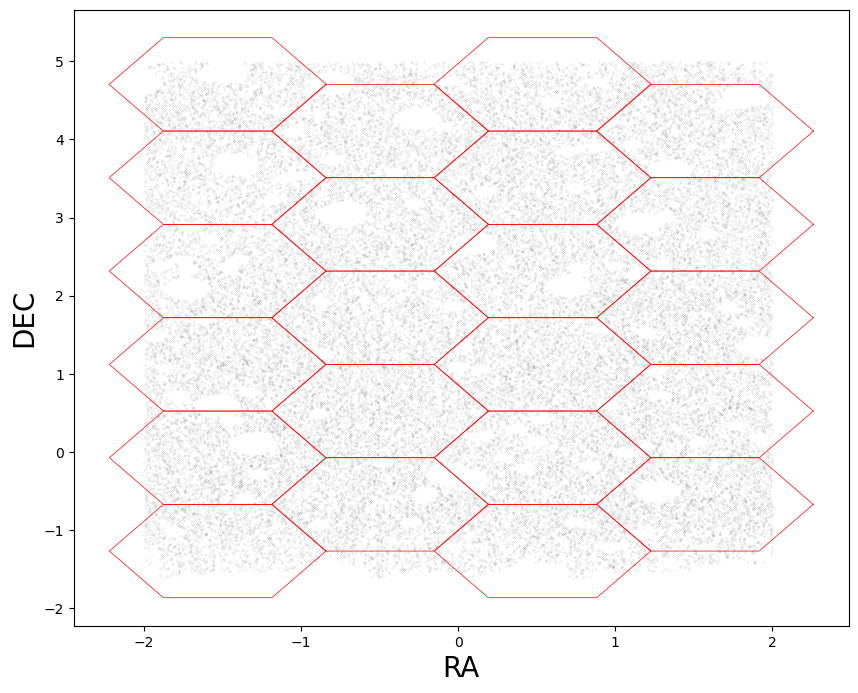

Time for plotting the pointings: 2.042 sec.
Pointing centers are saved to ../output/pointings/test/cosmology_region3_3h_pointings.ecsv


In [54]:
if __name__ == "__main__":
    # TODO: revise the xscale and yscale for the final realistic tiling strategy, note that PA=0 (full) and PA=90 (xml), the strategy is different
    xscale = 1. # 0-1., 1. is minimum/no overlapping 
    yscale = 1. # 0-1., 1. is minimum/no overlapping

    # TODO: change the ra, dec range 
    ra_range, dec_range = [-2, 2], [-5, 5]
    
    t0 = time.time()

    # read the scientific targets
    data_dir = '../data_proc/'
    prefix = 'cosmology_region3'
    cos_data_table = read_targets(data_dir, prefix, fmt='fits')

    raCos = cos_data_table['R.A.']
    decCos = cos_data_table['Dec.']
    nCos = len(raCos)

    # wrap the ra to [-180, 180] for the HSC wide autumn field
    raCos[raCos>300] -= 360

    t1 = time.time()
    print("Time for reading the scientific targets: %.3f sec." % (t1-t0))
    
    # quick statistics + set the range for getting pointing centers
    ra_min, ra_max, dec_min, dec_max = raCos.min(), raCos.max(), decCos.min(), decCos.max()
    print("%.3f<ra<%.3f, %.3f<dec<%.3f." % (ra_min, ra_max, dec_min, dec_max))
    print("There are %d scientific targets." % nCos)

    # get the pointing centers
    peaks = predefine_pointing_centers(ra_min, ra_max, dec_min, dec_max, xscale, yscale)
    print("There are %d pointings." % len(peaks))

    t2 = time.time()        
    print("Time for getting the pointing centers: %.3f sec." % (t2-t1))
    
    # plot the pointing and samples (filter out the fov w/o enough scientific targets)
    # TODO: plot for the whole region
    # plot for a small region
    mask_cos = (raCos>ra_range[0]) & (raCos<ra_range[1]) & (decCos>dec_range[0]) & (decCos<dec_range[1])
    mask_peak_ra = (peaks[:, 0]>ra_range[0]) & (peaks[:, 0]<ra_range[1]) & (peaks[:, 1]>dec_range[0]) & (peaks[:, 1]<dec_range[1])
    #mask_cos = np.ones(nCos, dtype=bool)
    #mask_peak_ra = np.ones(len(peaks), dtype=bool)

    plt.figure(figsize=(10, 8))
    print("  Your sample (gray), with the pointings (red):")
    plt.plot(raCos[mask_cos][::10], decCos[mask_cos][::10], 'k.', ms=0.2, alpha=0.5)

    mask_peaks_reserved = []
    for peak in peaks[mask_peak_ra]:
        flag_reserved = plot_filter_fov(peak[0], peak[1], raCos[mask_cos], decCos[mask_cos], PA=90, n_sci_fov_least=3000, filter_fov=True)
        mask_peaks_reserved.append(flag_reserved)

    plt.xlabel('RA', fontsize=20)
    plt.ylabel('DEC', fontsize=20)
    plt.savefig('../output/figures/test/%s_3h_fov_plot.png'%(prefix))
    plt.show()
    plt.close()
    
    t3 = time.time()
    print("Time for plotting the pointings: %.3f sec." % (t3-t2))

    # make the pointing center ra to [0, 360] for the output
    peaks[peaks[:, 0]<0, 0] += 360

    # TODO: save the reserved pointings of the whole region, not the region masked by mask_peak_ra
    out_dir = '../output/pointings/test/'
    save_pointings(peaks[mask_peak_ra][mask_peaks_reserved], out_dir+'%s_3h_pointings.ecsv'% prefix)